In [1]:
import time as clock
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


$\frac{\partial T}{\partial t} - \frac{{\partial}^2 T}{\partial x^2} = 0$

$ T(t, x) = 2 + e^{-4 \pi^2 t} sin(2\pi x) + e^{-16\pi^2 t} cos(4\pi x)$, $x\in[0,1], t\in[0, 0.05]$
$\\$$T_0 = T(0, x) = 2 + sin(2\pi x) + cos(4\pi x)$

$$loss1 = 0.0005820306250825524$$

$$loss2 = 0.0003718257066793741$$

$$loss3 = 0.0008028125739656389$$

In [2]:
#define amount of sample points
N = 2000

In [3]:
def thermal_conductivity_equation(x):
    return (2 + torch.exp(-4*(torch.pi**2)*x[0])*torch.sin(2*torch.pi*x[1]) + torch.exp(-16*(torch.pi**2)*x[0])*torch.cos(4*torch.pi*x[1]))

# function depicting a real graph and a predicted one
def check_current_situation(cur_model):
    x = torch.linspace(0, 1, 100)
    time = torch.zeros(100)
    real_temp = thermal_conductivity_equation([time, x])

    test_points = torch.stack((time, x), axis = -1)

    pinn_temp = cur_model(test_points)

    plt.plot(x.detach(), pinn_temp.detach())
    plt.plot(x, real_temp)

    plt.plot()
    plt.show()

In [4]:
x_physics = torch.rand(N).requires_grad_(True)
time_physics = 0.05 * torch.rand(N).requires_grad_(True)

points_for_pinn_model = torch.stack((time_physics, x_physics), -1)
boundary_condition_points = torch.stack((torch.zeros(N), x_physics), -1)

torch.manual_seed(123)

In [5]:
#define the class PINN
class PINN(nn.Module):
    def __init__(self, input_layer = 2, hidden_layer = 64, number_layers = 3, output_layer = 1):
        super().__init__()
        
        activation = nn.Tanh
        
        self.fcs = nn.Sequential(*
            [
                nn.Linear(input_layer, hidden_layer),
                activation()
            ]
        )
        
        self.fch = nn.Sequential(*
            [
                nn.Sequential(*
                    [
                        nn.Linear(hidden_layer, hidden_layer),
                        activation()
                    ]
                ) for _ in range(number_layers - 1)
            ]
        )
        
        self.fce = nn.Linear(hidden_layer, output_layer)
        
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        
        return x

In [9]:
def loss_weights(loss_data, loss_bound, loss_phys):
    w_bound = 1.0
    w_data = 1.0 / (1 + np.sqrt(20000) * loss_bound)
    w_phys = 1.0 / ((1 + np.sqrt(20000) * loss_bound) * (1 + np.sqrt(2000) * loss_data))
    #return w_data / (w_bound + w_data + w_phys), w_bound / (w_bound + w_data + w_phys), w_phys / (w_bound + w_data + w_phys)
    return w_data, w_bound, w_phys

In [10]:
pinn_model = PINN()
optimizer = torch.optim.Adam(pinn_model.parameters(), lr=0.001)
#optimizer = torch.optim.Adam(pinn_model.parameters(), lr = 0.001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 2500, gamma=0.7)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor = 0.8)

In [13]:
epochs = 20000

optimizer.param_groups[0]['lr'] = 0.001
for cur_epoch in range(epochs):
    optimizer.zero_grad()
    
    boundary_condition_temp = pinn_model(boundary_condition_points)
    network_temp = pinn_model(points_for_pinn_model).requires_grad_(True)
    
    # compute the "data loss"
    loss1 = torch.mean((thermal_conductivity_equation([time_physics, x_physics]).view(-1,1) - network_temp)**2).requires_grad_(True)
    loss2 = torch.mean((thermal_conductivity_equation([torch.zeros_like(x_physics), x_physics]).view(-1,1) - boundary_condition_temp)**2)
    
    network_temp = pinn_model(points_for_pinn_model)
    
    dt = torch.autograd.grad(network_temp, time_physics, torch.ones_like(network_temp), create_graph=True)[0]

    # compute dy/dx
    dx = torch.autograd.grad(network_temp, x_physics, torch.ones_like(network_temp), create_graph=True)[0]
    
    # compute d^2y/dx^2
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]
    
    # compute the "physics loss"
    loss3 = torch.mean((dt - dx2)**2)
    dist = loss1+loss2+loss3
    
    loss = 0.3*loss1 + 0.5*loss2 + 0.2*loss3
    loss = 0.3*loss1 + 0.5*loss2 + 0.2*loss3 # 0.3 0.6 0.1 - good
#     w1, w2, w3 = loss_weights(loss1, loss2, loss3)
#     loss = w1*loss1 + w2*loss2 + w3*loss3
    
    loss.backward(retain_graph=True)

    optimizer.step()
    #scheduler.step()
    if cur_epoch % 250 == 0:
        print(f'epoch: {cur_epoch}\tloss: {float(dist.detach().numpy()), float(loss1.detach().numpy()), float(loss2.detach().numpy()), float(loss3.detach().numpy())}\t')
#         print(f'weights: {float(w1.detach().numpy()), w2, float(w3.detach().numpy())}\n')
#     if cur_epoch % 5000 == 0:
#         check_current_situation(pinn_model) 

epoch: 0	loss: (0.17119884490966797, 0.02939465083181858, 0.09578163176774979, 0.04602256417274475)	
epoch: 250	loss: (0.16528268158435822, 0.028073163703083992, 0.10087001323699951, 0.03633950650691986)	
epoch: 500	loss: (0.16476470232009888, 0.02766343764960766, 0.10161493718624115, 0.03548631817102432)	
epoch: 750	loss: (0.16447818279266357, 0.027559174224734306, 0.10184746235609055, 0.03507155179977417)	
epoch: 1000	loss: (0.16422691941261292, 0.027514327317476273, 0.10197639465332031, 0.03473619744181633)	
epoch: 1250	loss: (0.16397994756698608, 0.027483893558382988, 0.1020740270614624, 0.034422021359205246)	
epoch: 1500	loss: (0.16372770071029663, 0.027461787685751915, 0.10215567797422409, 0.034110233187675476)	
epoch: 1750	loss: (0.16346535086631775, 0.027443356812000275, 0.10222786664962769, 0.03379414230585098)	
epoch: 2000	loss: (0.16319067776203156, 0.027429262176156044, 0.10228950530290604, 0.033471912145614624)	
epoch: 2250	loss: (0.16290175914764404, 0.027421439066529274,

epoch: 19500	loss: (0.09455776959657669, 0.02527601085603237, 0.05377527326345444, 0.015506480820477009)	
epoch: 19750	loss: (0.09370778501033783, 0.025171736255288124, 0.05304429680109024, 0.015491753816604614)	


# Boundary condition
## $T_0 = T(0, x) = 2 + sin(2\pi x) + cos(4\pi x)$

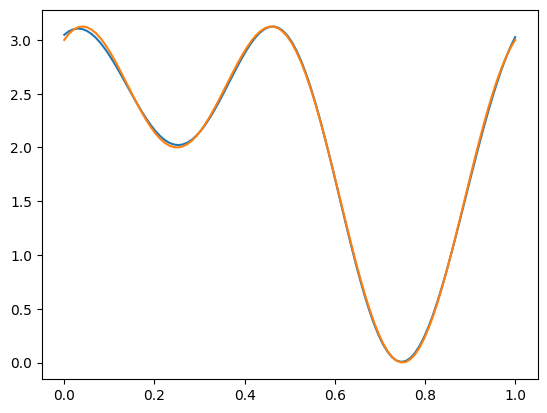

In [50]:
check_current_situation(pinn_model)

In [42]:
pinn_model(points_for_pinn_model)

tensor([[2.0062],
        [2.0194],
        [2.0054],
        ...,
        [2.0142],
        [2.0238],
        [2.0115]], grad_fn=<AddmmBackward0>)

In [47]:
torch.mean(thermal_conductivity_equation([time_physics, x_physics]).view(-1,1) - pinn_model(points_for_pinn_model))

tensor(-0.0220, grad_fn=<MeanBackward0>)

In [46]:
thermal_conductivity_equation([time_physics, x_physics]).view(-1,1)


tensor([[2.1422],
        [1.9769],
        [2.2335],
        ...,
        [1.8930],
        [2.6954],
        [1.9622]], grad_fn=<ViewBackward0>)

In [48]:
torch.zeros_like(x_physics)

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [49]:
x_physics

tensor([0.2961, 0.5166, 0.2517,  ..., 0.9463, 0.4930, 0.9744],
       requires_grad=True)

In [18]:
loss

tensor(0.4818, grad_fn=<AddBackward0>)

In [40]:
thermal_conductivity_equation([torch.zeros_like(x_physics), x_physics]).view(-1,1)

tensor([[2.0321],
        [2.5433],
        [1.0441],
        ...,
        [0.6156],
        [0.0254],
        [2.3702]], grad_fn=<ViewBackward0>)

In [42]:
pinn_model(boundary_condition_points) - thermal_conductivity_equation([torch.zeros_like(x_physics), x_physics]).view(-1,1)

tensor([[ 0.2132],
        [-0.1119],
        [ 0.0549],
        ...,
        [ 0.1027],
        [ 0.1308],
        [ 0.1093]], grad_fn=<SubBackward0>)

In [12]:
print(f'epoch: {cur_epoch}\tloss: {float(dist.detach().numpy()), float(loss1.detach().numpy()), float(loss2.detach().numpy()), float(loss3.detach().numpy())}\t')


epoch: 14871	loss: (0.17119884490966797, 0.02939465083181858, 0.09578163176774979, 0.04602256417274475)	
